In [4]:
#https://analyticsindiamag.com/convert-a-sketch-into-colored-image-using-cgan/
from zipfile import ZipFile

file_name ="/content/cGans-master.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [28]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from google.colab import drive
input_path = '/content/cGans-master/pokemon_pix2pix_dataset'

def image_loader(image_file):
  image_read = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image_read)
  dim = tf.shape(image)[1]
  dim=dim//2
  input = image[:, :dim, :]
  original = image[:,dim:, :]
  input = tf.cast(input, tf.float32)
  original = tf.cast(original,tf.float32)
  return input, original



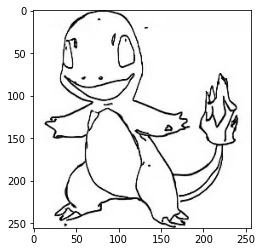

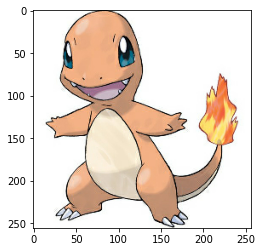

In [29]:
#Loading and visualizing the dataset
inp_img,orig_img = image_loader(input_path+'/train/3.jpg')
plt.figure()
plt.imshow(inp_img/255.0)
plt.figure()
plt.imshow(orig_img/255.0)

In [30]:
#Data augmentation
def resize_image(input,original, height, width):
        input=tf.image.resize(
            input[height,width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        original=tf.image.resize(original,[height,width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return input, original

def cutout(input, original):
  stacked = tf.stack([input, original], axis=0)
  cut_image = tf.image.random_crop(stacked, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cut_image[0], cut_image[1]

def normalize(input, original):
    input = (input / 127.5) - 1
    original = (original / 127.5) - 1
    return input, original

def add_noise(input, original):
  input,original = resize_image(input,original, 256, 256)
  input,original = cutout(input,original)
  if tf.random.uniform(()) > 0.5:
    input = tf.image.flip_left_right(input)
    original = tf.image.flip_left_right(original)
  return input,original


In [31]:
#Generator model 


def build_model_downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.,0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  #result.add(tf.keras.layers.LeakyReLU())
  result.add(tf.keras.layers.RelU())
  return result

def bild_model_upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.,0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, striders=2, padding='same',
                                      kernel_initializer=initialiser, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

  def Generator():
    down_stack = [
                  build_model_downsample(64,4,apply_batchnorm=False),
                  build_model_downsample(128,4),
                  build_model_downsample(256, 4),
                  build_model_downsample(512, 4), 
                  build_model_downsample(512, 4),
                  build_model_downsample(512, 4), 
                  build_model_downsample(512, 4), 
                  build_model_downsample(512, 4),                  
    ]
    up_stack = [
               build_model_upsample(512, 4, apply_dropout=True),
               build_model_upsample(512, 4, apply_dropout=True),
               build_model_upsample(512, 4, apply_dropout=True),
               build_model_upsample(512, 4),
               build_model_upsample(256, 4),
               build_model_upsample(128, 4),
               build_model_upsample(64, 4),
               ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') 
  concat = tf.keras.layers.Concatenate()
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)



In [32]:
#Discriminator model 
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  input = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  target = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
  concat= tf.keras.layers.concatenate([input, target]) 
  layer1 = downsample(64, 4, False)(concat)
  layer2 = downsample(128, 4)(layer1) 
  layer3 = downsample(256, 4)(layer2) 
  pad1 = tf.keras.layers.ZeroPadding2D()(layer3) 
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(pad1) 
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(pad2) 
  return tf.keras.Model(inputs=[input, target], outputs=last)

In [33]:
#Loss functions
def discriminator_loss(disc_real_output, disc_generated_output):
  actual_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total = actual_loss + generated_loss
  return total

alpha = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  mean_error = tf.reduce_mean(tf.abs(target - gen_output))
  total = gan_loss + (alpha *mean_error)
  return total




In [34]:
#Training 
def load_training_data(image_file):
  input,original = image_loader(image_file)
  input,original = add_noise(input,original)
  input,original= normalize(input,original)
  return input,original


train_image = tf.data.Dataset.list_files(input_path+'/train/*.jpg')
train_image = train_image.map(load_training_data,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_image= train_image.cache().shuffle(BUFFER_SIZE)
train_image= train_image.batch(1)


TypeError: ignored

In [39]:
def load_test_data(image_file):
  input,original = image_loader(image_file)
  input,original = add_noise(input,original)
  input,original= normalize(input,original)
  return input,original
test_image = tf.data.Dataset.list_files(input_path+'/test/*.jpg')
test_image = test_image.map(load_test_data,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_image= test_image.cache().shuffle(BUFFER_SIZE)
test_image= test_image.batch(1)
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS =101
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'ground_truth', 'Predicted Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()
    for input_image, target in train_ds:
      train_step(input_image, target)
    clear_output(wait=True)
    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    if (epoch + 1) % 20 == 0:
          print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
fit(train_dataset, EPOCHS, test_dataset)

TypeError: ignored